### Frank Wolfe / Conditional gradient method in practice

In this notebook, we will consider the problem of matrix completion, which is described as a rank-constrained problem, in its original form:

$$ 
\min_{X: \text{rank}(X) \leq r} f(X)
$$

where $f$ is a convex function.

Since we focus on the Frank Wolfe algorithm, we will particularly consider its convex relaxation:

$$
\text{rank}(X) \leq r \Rightarrow \|X\|_* \leq \alpha
$$

Here, $\|X\|_*$ denotes the nuclear norm, computed as the sum of the singular values of $X$:

$$ 
\|X\|_* = \sum_{i = 1}^p \sigma_i(X)
$$

Let us see how we can compute the nuclear norm from scratch:

In [5]:
%matplotlib inline

import numpy as np
from timeit import timeit

"""Common plotting subroutines."""

fontsize = 20

import matplotlib
import matplotlib.pyplot as plt

kwargs = {'linewidth' : 3.5}
font = {'weight' : 'normal', 'size'   : 24}


def error_plot(ys, yscale='log'):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys)), ys, **kwargs)
    

def convergence_plot(fs, gs):
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.title('Convergence in objective')    
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.plot(range(len(fs)), fs, **kwargs)
    plt.subplot(122)
    plt.title('Convergence in domain')    
    plt.xlabel('Step')
    plt.yscale('log')
    plt.plot(range(len(gs)), gs, **kwargs)
    plt.tight_layout()


def setup_layout():
    display(HTML(open('custom.html').read()))
    matplotlib.rc('font', **font)


In [6]:
def gradient_descent(init, step_sizes, grad, Pi_C = lambda X: X):    
    X = [init]
    for step in step_sizes:
        X.append(Pi_C(X[-1] - step * grad(X[-1])))
    return X

In [7]:
def nuclear_norm(A):
    return np.sum(np.linalg.svd(A)[1])

In [8]:
A = np.random.randn(100, 100)
nuc_A = nuclear_norm(A)
print(nuc_A)

852.8908970088726


In [9]:
A = np.identity(10)
nuc_A = nuclear_norm(A)
print(nuc_A)

10.0


#### Matrix completion

The task of matrix completion can be described as:

$$ 
\min_{X: \text{rank}(X) \leq r} \tfrac{1}{2} \cdot \|P_{\Omega}(X - X^\star)\|_F^2.
$$
Here, $X^\star \in \mathbb{R}^{p \times p}$ is an unknown low rank matrix (we assume it has rank $r$ and we also assume that we know its rank); $\Omega$ is a set of indices from $[p] \times [p]$ that represents the set of entries that we observe from $X^\star$; $P_{\Omega}$ then represents the observation mask, as defined by $\Omega$.

Just to get a sense of what we described above, if $\Omega$ contains all the indices in $[p] \times [p]$, themn the above observation mask is just the identity mask, and our problem becomes:

$$
\min_{X: \text{rank}(X) \leq r} \tfrac{1}{2} \cdot \|X - X^\star\|_F^2.
$$

What is the solution to this problem?

As long as $P_{\Omega}$ is not the identity matrix, the problem becomes non-trivial.
Especially, when the cardinality $n = |\Omega|$ is much less than the set of variables, $p^2$:

$$
n \ll p^2
$$

However, even in this case, there are conditions that can guarantee convergence (and will be discussed later on in the semester). For the moment, what we need to know is that the convex relaxation of the above problem can guarantee the reconstruction $X^\star$ from a small number of observations:

$$
\min_{X: \|X\|_* \leq \alpha} \tfrac{1}{2} \cdot \|P_{\Omega}(X - X^\star)\|_F^2.
$$

For a properly selected value of $\alpha$. (BTW, how can we set up $\alpha$?)

Let us start building our code to accommodate both projected gradient descent, as well as Frank-Wolfe methods.

In [10]:
p = 500
r = 10

U = np.random.normal(0, 1, (p, r))
U = np.linalg.qr(U)[0]

V = np.random.normal(0, 1, (p, r))
V = np.linalg.qr(V)[0]

S = np.diag(np.random.uniform(0, 1, r))
S /= np.sum(S)

X_star = U.dot(S.dot(V.T))

print(nuclear_norm(X_star))

1.0000000000000062


In [11]:
Omega = np.random.randint(0, 2, (p, p))
print(Omega)
m = np.count_nonzero(Omega)
print(m)
print(m/p**2)

[[0 1 0 ... 0 0 0]
 [1 0 1 ... 1 0 1]
 [0 1 0 ... 0 0 1]
 ...
 [0 1 1 ... 0 0 1]
 [1 1 1 ... 0 1 1]
 [1 1 0 ... 1 0 1]]
124953
0.499812


In [12]:
X_star_obs = np.multiply(X_star, Omega)

def MC_function(X_star_obs, Omega, X):
    return 0.5 * np.linalg.norm(X_star_obs - np.multiply(X, Omega), 'fro')**2

def MC_gradient(X_star_obs, Omega, X):
    return np.multiply(X, Omega) - X_star_obs

#### Projected gradient descent approach

We will start with projected gradient descent for this problem. As you can see from the definition of the algorithm above, we need the definition of the projection:

$$
\min_{\|X\|_* \leq \alpha} \tfrac{1}{2} \|X - Y\|_F^2
$$

We have seen in the class how the low-rank projection relates to the sparsity projection; similarly, one can show that the projection onto bounded nuclear norm matrices relates to the projection of the $\ell_1$-norm for vectors. Why is that?

In [13]:
def simplex_projection(s):
    if np.sum(s) <=1 and np.alltrue(s >= 0):
        return s
    # Code taken from https://gist.github.com/daien/1272551
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, len(u)+1) > (cssv - 1))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - 1) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    return np.maximum(s-theta, 0)

def nuclear_projection(X):
    U, S, V = np.linalg.svd(X, full_matrices=False)
    S = simplex_projection(S)
    return U.dot(np.diag(S).dot(V))

In [14]:
X = np.random.randn(p, p)
print(nuclear_norm(X))

9487.695835875522


In [15]:
proj_X = nuclear_projection(X)
print(nuclear_norm(proj_X))

1.0000000000000253


Excellent, we have defined how we can do the projection onto the convex set of bounded nuclear norm matrices! Now, we have all the ingredients to run projected gradient descent:

In [16]:
X_init = np.random.normal(0,1, (p, p))
X_init = nuclear_projection(X_init)

grad = lambda X: MC_gradient(X_star_obs, Omega, X)

X = gradient_descent(X_init, [0.2]*30, grad, nuclear_projection)

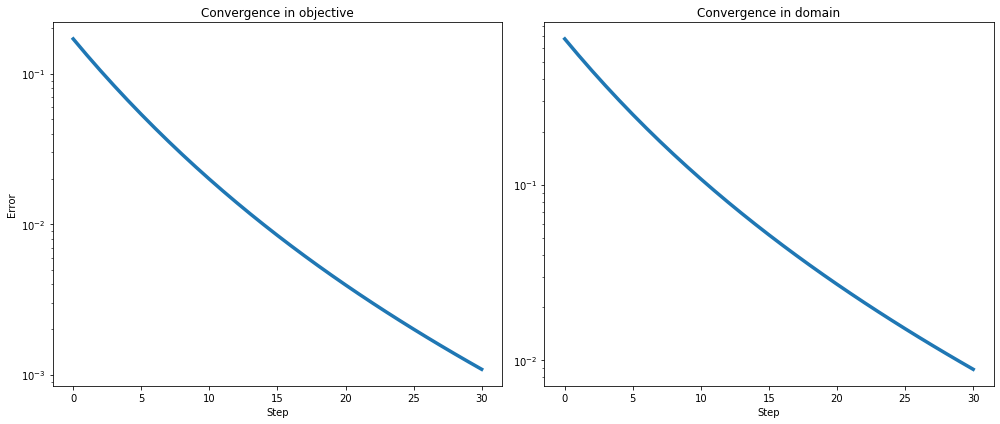

In [17]:
func = lambda X: MC_function(X_star_obs, Omega, X)

convergence_plot([func(Y) for Y in X],
                [np.linalg.norm(X_star - Y, 'fro')**2 for Y in X])

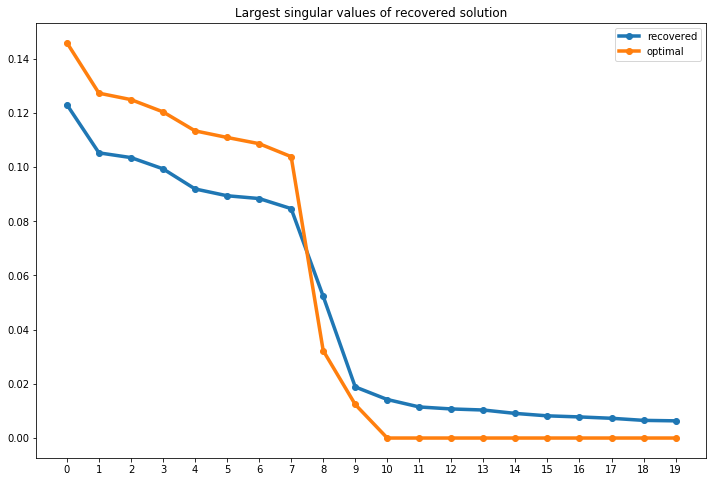

In [18]:
_, S_opt, _ = np.linalg.svd(X_star, full_matrices=False)
_, S, _ = np.linalg.svd(X[-1], full_matrices=False)

plt.figure(figsize=(12,8))
plt.title('Largest singular values of recovered solution')
plt.plot(range(20), np.sort(S)[::-1][:20], 'o-', label='recovered', **kwargs)
plt.plot(range(20), np.sort(S_opt)[::-1][:20], 'o-', label='optimal', **kwargs)
plt.xticks(range(20))
plt.legend()

But how much expensive it is to compute the projection?

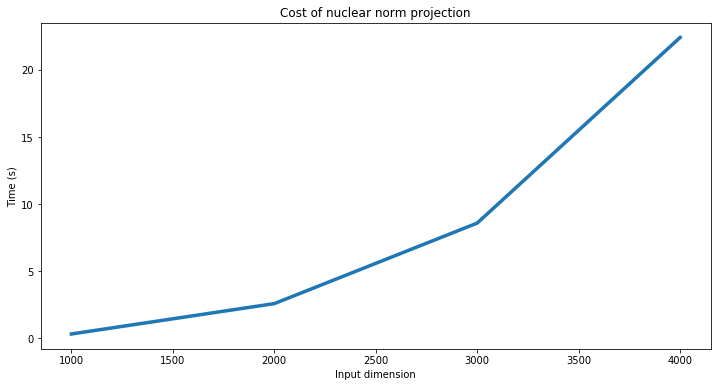

In [19]:
ts = []
ns = [1000, 2000, 3000, 4000]
for n in ns:
    f = lambda: nuclear_projection(np.random.normal(0,1,(n, n)))
    ts.append(timeit(f, number=1))
    
plt.figure(figsize=(12,6))
plt.xlabel('Input dimension')
plt.ylabel('Time (s)')
plt.title('Cost of nuclear norm projection')
plt.plot(ns, ts, **kwargs)

#### Conditional gradient method

In [20]:
def FW(init, step_sizes, LMO):    
    X = [init]
    for step in step_sizes:
        X.append(X[-1] + step*(LMO(X[-1]) - X[-1]))
    return X

In [21]:
def power_method(X, num_steps=10):
    m, n = X.shape
    x = np.random.normal(0,1, m)
    x /= np.linalg.norm(x)
    y = X.T.dot(x)
    y /= np.linalg.norm(y)
    for _ in range(num_steps):      
        x = X.dot(y)
        x /= np.linalg.norm(x)
        y = X.T.dot(x)
        y /= np.linalg.norm(y)        
    return x, y

In [22]:
def MC_LMO(X_star_obs, Omega, X):
    g = MC_gradient(X_star_obs, Omega, X)
    x, y = power_method(-g)
    return x.reshape((len(x), 1)).dot(y.reshape((1,len(y))))

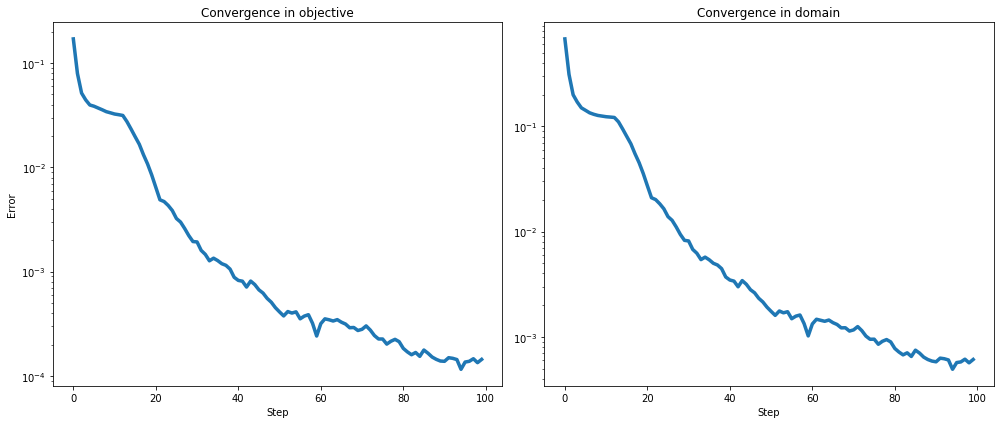

In [23]:
LMO = lambda X: MC_LMO(X_star_obs, Omega, X)
step_sizes = [2./(k+2.) for k in range(1, 100)]

X_FW = FW(X_init, step_sizes, LMO)

convergence_plot([func(Y) for Y in X_FW],
                [np.linalg.norm(X_star - Y, 'fro')**2 for Y in X_FW])

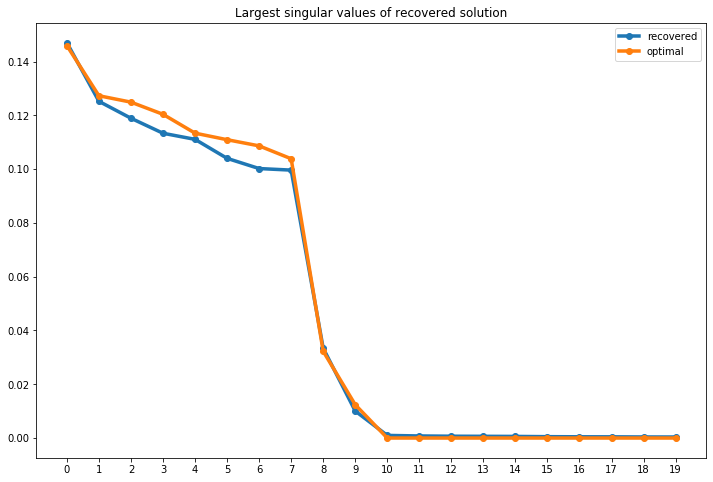

In [24]:
_, S_opt, _ = np.linalg.svd(X_star, full_matrices=False)
_, S, _ = np.linalg.svd(X_FW[-1], full_matrices=False)

plt.figure(figsize=(12,8))
plt.title('Largest singular values of recovered solution')
plt.plot(range(20), np.sort(S)[::-1][:20], 'o-', label='recovered', **kwargs)
plt.plot(range(20), np.sort(S_opt)[::-1][:20], 'o-', label='optimal', **kwargs)
plt.xticks(range(20))
plt.legend()

So both of the algorithms seem to perform well, and similarly in terms of iterations. How do they compare in terms of computational complexity?

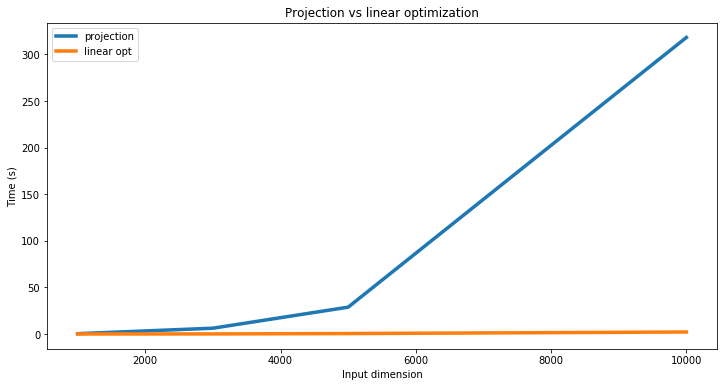

In [53]:
ts1 = []
ts2 = []
ns = [1000, 3000, 5000, 10000]
for n in ns:
    f = lambda: nuclear_projection(np.random.normal(0,1,(n, n)))
    ts1.append(timeit(f, number=1))
    
    Y = np.random.normal(0,1, (n, n))
    O = np.random.randint(0, 2, (n, n))
    X = np.random.normal(0,1, (n, n))
    f = lambda: MC_LMO(Y, O, X)
    ts2.append(timeit(f, number=1))
    
    
plt.figure(figsize=(12,6))
plt.xlabel('Input dimension')
plt.ylabel('Time (s)')
plt.title('Projection vs linear optimization')
plt.plot(ns, ts1, label='projection', **kwargs)
plt.plot(ns, ts2, label='linear opt', **kwargs)
plt.legend()